<a href="https://colab.research.google.com/github/MesutEmpire-CS-Projects/Road-Classifier-Model/blob/main/TRAFFIC_CLASSIFIER_FINAL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# 1. Data Preparation

## 1.1 Import the data

In [ ]:
traffic_data = pd.read_excel('drive/MyDrive/CS 4.1/KNOWLEDGE BASED SYSTEMS/Assignments/TRAFFIC ACCIDENTS DATA.xlsx')
print(traffic_data.columns)
traffic_data.head()

Index(['Date', 'Accident Spot', 'Area', 'County', 'Road/ Highway',
       'Brief Accident Details/Cause', 'Victims',
       'Total people confirmed dead', 'Time of the Accidents',
       'Weather conditions'],
      dtype='object')


,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,Passengers,4,4.30 pm,NaN
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,Passengers,1,5.50 pm,NaN
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,Drivers/Occupants,4,NaN,NaN
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,Driver and passengers,3,6.00 pm,NaN
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,Pedestrian,1,NaN,NaN


## 1.2 Identify Missing Values

In [ ]:
display(traffic_data.isna().sum())

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,1
Brief Accident Details/Cause,2
Victims,18
Total people confirmed dead,9
Time of the Accidents,56
Weather conditions,80


## 1.3 Fill Missing Values

In [ ]:
# Convert 'Total people confirmed dead' to numeric values, coercing errors to NaN
traffic_data['Total people confirmed dead'] = pd.to_numeric(traffic_data['Total people confirmed dead'], errors='coerce')

# Group by 'Road/ Highway' and 'Accident Spot', then calculate the mean
mean_deaths = traffic_data.groupby(['Road/ Highway', 'Accident Spot'])['Total people confirmed dead'].transform('mean')

# Fill NaN values in 'Total people confirmed dead' with the calculated mean
traffic_data['Total people confirmed dead'].fillna(mean_deaths, inplace=True)

# If mean for a group is still NaN (no valid data for that group), fill with 0 as a fallback
traffic_data['Total people confirmed dead'].fillna(0, inplace=True)

# Verify the changes
print(traffic_data[['Road/ Highway', 'Accident Spot', 'Total people confirmed dead']].head())


                 Road/ Highway Accident Spot  Total people confirmed dead
0       Nakuru-Eldoret Highway         Sobea                          4.0
1  Maai-Mahiu Naivasha Highway    Maai-Mahiu                          1.0
2         Narok Mai Mahiu road       Ntulele                          4.0
3         Narok Mai Mahiu road         Suswa                          3.0
4       Kerugoya-Karatina Road        Mutira                          1.0


In [ ]:
traffic_data['Weather conditions'].fillna("Unknown", inplace=True)
traffic_data['Time of the Accidents'].fillna("Unknown", inplace=True)
traffic_data['Victims'].fillna("Unknown", inplace=True)

In [ ]:
# Fill remaining NaNs in text fields with a placeholder
for col in ['Accident Spot', 'Area', 'County', 'Road/ Highway']:
    traffic_data[col].fillna("Unknown", inplace=True)

## 1.4 Feature Creation

In [ ]:
traffic_data_encoded = traffic_data.copy()

In [ ]:
# Define the classify_risk function
def classify_risk(deaths):
    if deaths == 0:
        return 'Low'
    elif deaths <= 3:
        return 'Moderate'
    else:
        return 'High'

# Apply the function to classify Risk_Level
traffic_data_encoded['Risk_Level'] = traffic_data_encoded['Total people confirmed dead'].apply(classify_risk)

## 1.5 Encoding

In [ ]:
# Transforming text data into numerical form using Label Encoding
le = LabelEncoder()

text_cols = ['Accident Spot', 'Area', 'County', 'Road/ Highway', 'Weather conditions', 'Time of the Accidents','Risk_Level','Victims','Time of the Accidents']

# Apply label encoding
for col in text_cols:
    traffic_data_encoded[col] = le.fit_transform(traffic_data_encoded[col])

# Display processed features
print("Encoded Data:")
display(traffic_data_encoded.head())

Encoded Data:


,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions,Risk_Level
0,2023-08-08,53,56,19,29,Head on Collision,8,4.0,10,1,0
1,2023-08-07,24,38,19,14,vehicle and motorcycle collision,8,1.0,11,1,2
2,2023-07-25,43,45,20,31,Head on Collision,3,4.0,17,1,0
3,2022-12-02,55,58,20,31,Head on Collision,1,3.0,12,1,2
4,2022-12-01,37,36,7,7,Run over,12,1.0,17,1,2


## 1.6 Drop Columns

In [ ]:
traffic_data_encoded.isna().sum()

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,0
Brief Accident Details/Cause,2
Victims,0
Total people confirmed dead,0
Time of the Accidents,0
Weather conditions,0


In [ ]:
# Split into Features and Targets
traffic_data_ftrs = traffic_data_encoded.drop(columns=['Risk_Level','Brief Accident Details/Cause','Date'])
traffic_data_tgts = traffic_data_encoded['Risk_Level']

In [ ]:
traffic_data_encoded.isna().sum()

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,0
Brief Accident Details/Cause,2
Victims,0
Total people confirmed dead,0
Time of the Accidents,0
Weather conditions,0


## 1.7 Shuffle Dataset

In [ ]:
# Shuffle the dataset
traffic_data_ftrs, traffic_data_tgts = shuffle(traffic_data_ftrs, traffic_data_tgts, random_state=42)

## 1.8 Final Check

In [ ]:
print(f"Features Shape: {traffic_data_ftrs.shape}, Target Shape: {traffic_data_tgts.shape}")
display(traffic_data_ftrs.head())

Features Shape: (81, 8), Target Shape: (81,)


,Accident Spot,Area,County,Road/ Highway,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
30,52,54,0,26,15,5.0,6,1
0,53,56,19,29,8,4.0,10,1
22,20,35,9,11,9,0.0,17,1
31,36,34,16,22,0,1.0,17,1
18,22,24,19,28,2,52.0,13,1


# 2. Model Selection

In [ ]:
(traffic_train_ftrs,traffic_test_ftrs,traffic_train_tgts,traffic_test_tgts) = train_test_split(traffic_data_ftrs,traffic_data_tgts,test_size=0.2,random_state=42)
traffic_train_ftrs.head()
print(len(traffic_train_ftrs))
print(len((traffic_test_ftrs)))

64
17


In [ ]:
models = {
    'knn': KNeighborsClassifier,
    'naive_bayes': GaussianNB,
    # 'decision_tree': DecisionTreeClassifier,
    # 'random_forest': RandomForestClassifier,
    'logistic_regression': LogisticRegression,
    'svm': SVC,
    'mlp': MLPClassifier,
}

# Prepare data structure to store results
results = {name: [] for name in models}

display(results)


{'knn': [], 'naive_bayes': [], 'logistic_regression': [], 'svm': [], 'mlp': []}

In [ ]:
# Loop through each model performing cross validation
for name, model in models.items():
    for i in range(2, 10):
        if model == KNeighborsClassifier:
            for j in range(2, 10):
                score = cross_val_score(model(n_neighbors=j), traffic_train_ftrs, traffic_train_tgts,
                                        cv=StratifiedKFold(i), scoring='accuracy')
                mean_score = score.mean().round(2)
                results[name].append((i, j, mean_score))
        else:
            score = cross_val_score(model(), traffic_train_ftrs, traffic_train_tgts,
                                    cv=StratifiedKFold(i), scoring='accuracy')
            mean_score = score.mean()
            results[name].append((i, None, mean_score))

display(results)

{'knn': [(2, 2, 0.48),
  (2, 3, 0.47),
  (2, 4, 0.45),
  (2, 5, 0.45),
  (2, 6, 0.41),
  (2, 7, 0.47),
  (2, 8, 0.41),
  (2, 9, 0.45),
  (3, 2, 0.47),
  (3, 3, 0.48),
  (3, 4, 0.5),
  (3, 5, 0.5),
  (3, 6, 0.44),
  (3, 7, 0.45),
  (3, 8, 0.37),
  (3, 9, 0.39),
  (4, 2, 0.48),
  (4, 3, 0.42),
  (4, 4, 0.53),
  (4, 5, 0.48),
  (4, 6, 0.47),
  (4, 7, 0.47),
  (4, 8, 0.38),
  (4, 9, 0.38),
  (5, 2, 0.5),
  (5, 3, 0.39),
  (5, 4, 0.53),
  (5, 5, 0.53),
  (5, 6, 0.42),
  (5, 7, 0.45),
  (5, 8, 0.39),
  (5, 9, 0.39),
  (6, 2, 0.53),
  (6, 3, 0.45),
  (6, 4, 0.5),
  (6, 5, 0.5),
  (6, 6, 0.5),
  (6, 7, 0.53),
  (6, 8, 0.42),
  (6, 9, 0.36),
  (7, 2, 0.53),
  (7, 3, 0.43),
  (7, 4, 0.47),
  (7, 5, 0.53),
  (7, 6, 0.48),
  (7, 7, 0.52),
  (7, 8, 0.44),
  (7, 9, 0.4),
  (8, 2, 0.53),
  (8, 3, 0.45),
  (8, 4, 0.52),
  (8, 5, 0.5),
  (8, 6, 0.52),
  (8, 7, 0.53),
  (8, 8, 0.48),
  (8, 9, 0.41),
  (9, 2, 0.55),
  (9, 3, 0.45),
  (9, 4, 0.55),
  (9, 5, 0.53),
  (9, 6, 0.55),
  (9, 7, 0.56),
  (9, 8, 

In [ ]:
# Create the results dictionary into a DataFrame
data = [(model_name, cv_folds, n_neighbors, accuracy_score) for model_name, values in results.items() for cv_folds, n_neighbors, accuracy_score in values]
df = pd.DataFrame(data, columns=['Model', 'CV', 'Neighbors', 'Mean Score'])
df.set_index('Model', inplace=True)
display(df)

,CV,Neighbors,Mean Score
Model,,,
knn,2,2.0,0.480000
knn,2,3.0,0.470000
knn,2,4.0,0.450000
knn,2,5.0,0.450000
knn,2,6.0,0.410000
...,...,...,...
mlp,5,NaN,0.500000
mlp,6,NaN,0.589394
mlp,7,NaN,0.684127


In [ ]:
# Group the based on Model name
grouped_df = df.groupby('Model')

,CV,Neighbors,Mean Score
Model,,,
knn,2,2.0,0.48
knn,2,3.0,0.47
knn,2,4.0,0.45
knn,2,5.0,0.45
knn,2,6.0,0.41
...,...,...,...
knn,9,5.0,0.53
knn,9,6.0,0.55
knn,9,7.0,0.56


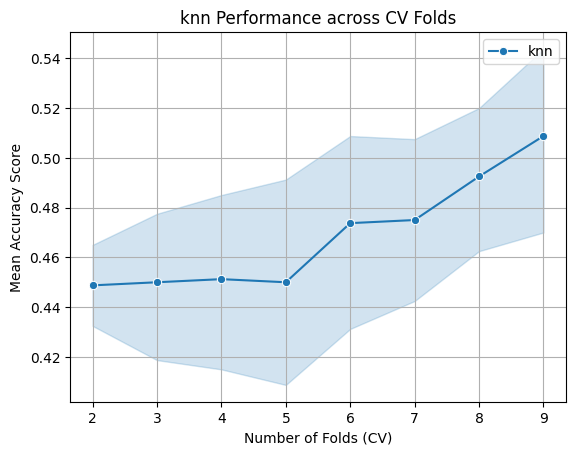

,CV,Neighbors,Mean Score
Model,,,
logistic_regression,2,NaN,0.765625
logistic_regression,3,NaN,0.859307
logistic_regression,4,NaN,0.843750
logistic_regression,5,NaN,0.843590
logistic_regression,6,NaN,0.856061
logistic_regression,7,NaN,0.814286
logistic_regression,8,NaN,0.890625
logistic_regression,9,NaN,0.863095


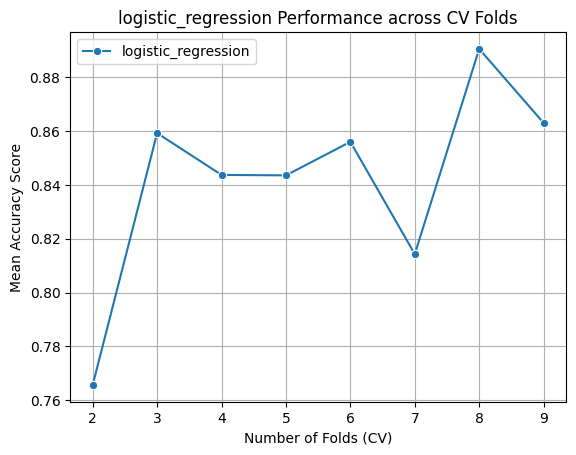

,CV,Neighbors,Mean Score
Model,,,
mlp,2,NaN,0.656250
mlp,3,NaN,0.621212
mlp,4,NaN,0.671875
mlp,5,NaN,0.500000
mlp,6,NaN,0.589394
mlp,7,NaN,0.684127
mlp,8,NaN,0.640625
mlp,9,NaN,0.658730


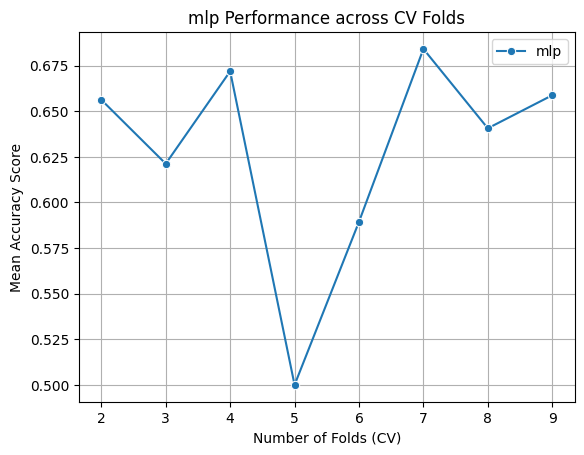

,CV,Neighbors,Mean Score
Model,,,
naive_bayes,2,NaN,0.875000
naive_bayes,3,NaN,0.874459
naive_bayes,4,NaN,0.828125
naive_bayes,5,NaN,0.875641
naive_bayes,6,NaN,0.843939
naive_bayes,7,NaN,0.828571
naive_bayes,8,NaN,0.828125
naive_bayes,9,NaN,0.829365


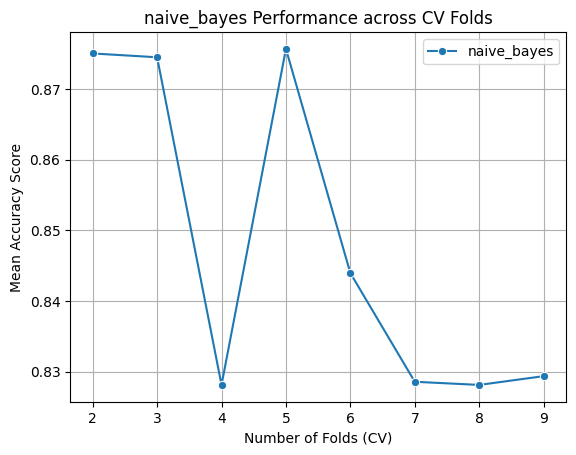

,CV,Neighbors,Mean Score
Model,,,
svm,2,NaN,0.453125
svm,3,NaN,0.373016
svm,4,NaN,0.390625
svm,5,NaN,0.373077
svm,6,NaN,0.450000
svm,7,NaN,0.401587
svm,8,NaN,0.437500
svm,9,NaN,0.432540


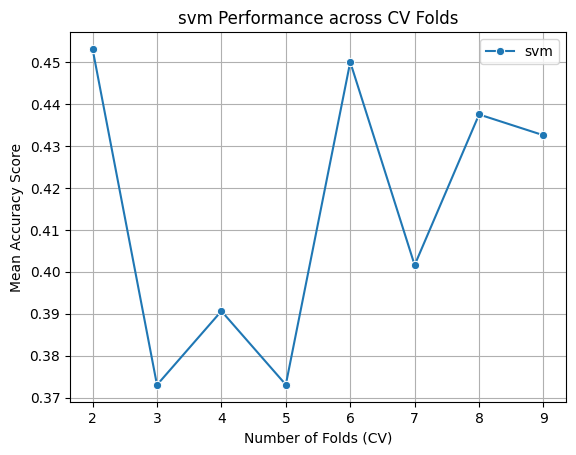

In [ ]:
for model_name, group in grouped_df:
    display(group)
    sns.lineplot(data=group, x='CV', y='Mean Score', hue='Model', marker='o')

    plt.title(f'{model_name} Performance across CV Folds')
    plt.xlabel('Number of Folds (CV)')
    plt.ylabel('Mean Accuracy Score')
    plt.grid(True)
    plt.legend()
    plt.show()

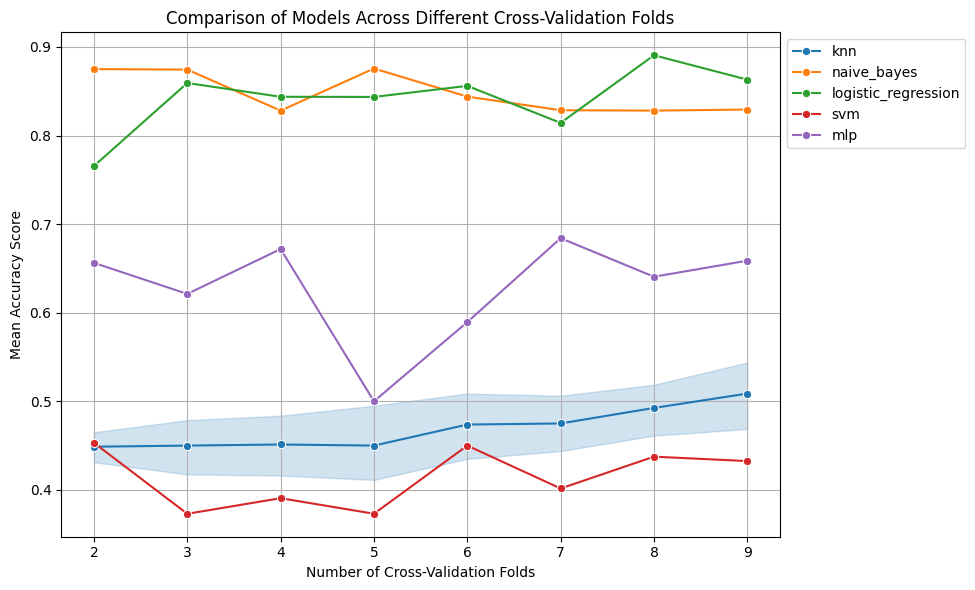

In [ ]:
# Plot the comparison across different CV folds for each model
plt.figure(figsize=(8, 6))

plt.title('Comparison of Models Across Different Cross-Validation Folds')
sns.lineplot(data=df, x='CV', y='Mean Score',hue='Model', marker='o')

plt.xlabel('Number of Cross-Validation Folds')
plt.ylabel('Mean Accuracy Score')
plt.legend(title='Model')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [ ]:
max_row = df[df['Mean Score'] == df['Mean Score'].max()]
print(max_row)
print(max_row['Neighbors'])

                     CV  Neighbors  Mean Score
Model                                         
logistic_regression   8        NaN    0.890625
Model
logistic_regression   NaN
Name: Neighbors, dtype: float64


In [ ]:
max_row.index[0]

'logistic_regression'

In [ ]:
best_dt_model = models[max_row.index[0]]()
fit = best_dt_model.fit(traffic_train_ftrs, traffic_train_tgts)
test_predictions = fit.predict(traffic_test_ftrs)
test_accuracy = accuracy_score(traffic_test_tgts,test_predictions)
train_accuracy = accuracy_score(traffic_train_tgts,fit.predict(traffic_train_ftrs))
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {train_accuracy}')

Test Accuracy: 1.0
Train Accuracy: 0.984375


In [ ]:
# best_dt_model = DecisionTreeClassifier()

# fit = best_dt_model.fit(traffic_train_ftrs, traffic_train_tgts)
# test_predictions = fit.predict(traffic_test_ftrs)
# test_accuracy = accuracy_score(traffic_test_tgts,test_predictions)
# train_accuracy = accuracy_score(traffic_train_tgts,fit.predict(traffic_train_ftrs))
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Train Accuracy: {train_accuracy}')

In [ ]:
# best_dt_model = RandomForestClassifier()
# fit = best_dt_model.fit(traffic_train_ftrs, traffic_train_tgts)
# test_predictions = fit.predict(traffic_test_ftrs)
# test_accuracy = accuracy_score(traffic_test_tgts,test_predictions)
# train_accuracy = accuracy_score(traffic_train_tgts,fit.predict(traffic_train_ftrs))
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Train Accuracy: {train_accuracy}')

In [ ]:
# best_dt_model = GaussianNB()
# fit = best_dt_model.fit(traffic_train_ftrs, traffic_train_tgts)
# test_predictions = fit.predict(traffic_test_ftrs)
# test_accuracy = accuracy_score(traffic_test_tgts,test_predictions)
# train_accuracy = accuracy_score(traffic_train_tgts,fit.predict(traffic_train_ftrs))
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Train Accuracy: {train_accuracy}')

# 3. Classifier Evalution

## 3.1 Confusion Matrix

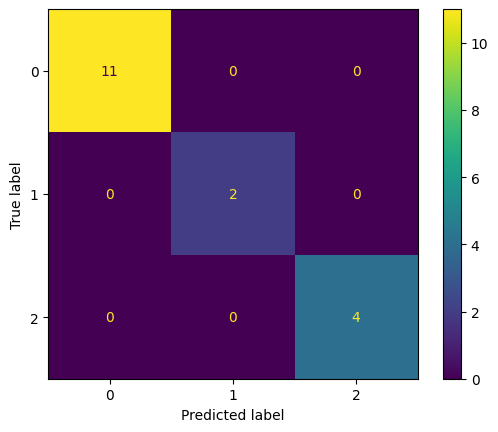

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(traffic_test_tgts, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

## 3.2 Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(traffic_test_tgts, test_predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



## 3.3 ROC AND AUC

In [ ]:
n_classes = traffic_test_tgts_bin.shape[1]
print(n_classes)

3


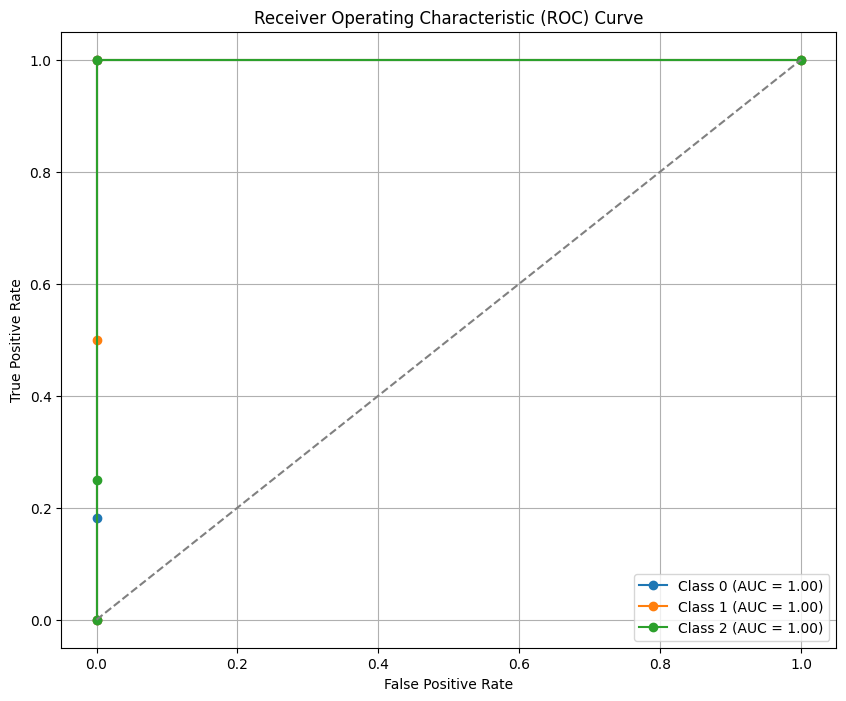

In [ ]:
# Binarize the output (traffic_test_tgts) for multi-class ROC curve
lb = LabelBinarizer()
traffic_test_tgts_bin = lb.fit_transform(traffic_test_tgts)

# Get predicted probabilities
probabilities = best_dt_model.predict_proba(traffic_test_ftrs)

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(traffic_test_tgts_bin[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for this class
    plt.plot(fpr, tpr, 'o-',label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the "chance" line (45-degree line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set plot labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import joblib
joblib.dump(best_dt_model, 'final_decision_tree_model.pkl')


['final_decision_tree_model.pkl']